# HW8

## Fiona Fan

In [3]:
import pandas as pd
import numpy as np
from ggplot import *
import matplotlib.pyplot as plt

import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
import warnings

warnings.filterwarnings("ignore") 
%matplotlib inline

In [4]:

#Import data
src = pd.read_csv('strongdrink.txt', sep = ',')
src.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [5]:

X = src[['alco', 'malic', 'tot_phen', 'color_int']].values
y = src['cultivar'].values

## 1a)

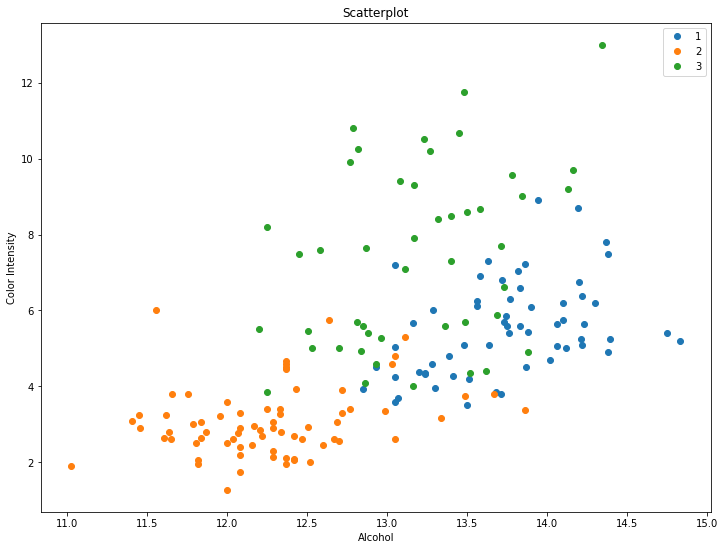

In [8]:
groups = src.groupby('cultivar')

fig, ax = plt.subplots(figsize=(12,9))
for name, group in groups:
    ax.plot(group['alco'], group['color_int'], marker='o', linestyle='', label=name)
ax.legend()
plt.xlabel('Alcohol')
plt.ylabel('Color Intensity')
plt.title('Scatterplot')
plt.show()

## b)

In [15]:
k = 4
kf = KFold(n_splits=k, random_state=22, shuffle=True)
kf.get_n_splits(X)
MSE = np.zeros(k)
C = np.zeros(200)
MSE_C = np.zeros(200)

for c in range(200):
    k_ind = int(0)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        LogReg = LogisticRegression(multi_class='multinomial', fit_intercept = True,
                                    solver='newton-cg', C = (c/100 + 0.01))
        LogReg.fit(X_train, y_train)
        y_pred = LogReg.predict(X_test)
        error = y_test != y_pred
        MSE[k_ind] = error.mean()
        k_ind += 1
    C[c] = c/100 + 0.01
    MSE_C[c] =  MSE.mean()
MSE_logit = pd.DataFrame({'C':C, 'MSE':MSE_C})

In [19]:
df_new = MSE_logit.sort_values(['MSE'])
df_new.head()

,C,MSE
43,0.44,0.068182
44,0.45,0.068182
42,0.43,0.068182
41,0.42,0.068182
40,0.41,0.068182


C = 0.44, penalty is 'l2', lowest MSE = 0.068182.
## 1c)

In [21]:

MSE_loop = pd.DataFrame({"n_estimator" : np.zeros(5),
                         "min_sample_leaf" : np.zeros(5),
                         "max_depth" : np.zeros(5),
                         "MSE" : np.zeros(5)})
MSE_RF = MSE_loop[:0]

for ml in range(15):
    for md in range(15):
        for tree in range(5):
            RF = RandomForestClassifier(n_estimators = (tree * 50 + 50),
                                        min_samples_leaf = (ml * 5 + 5),
                                        max_depth = (md + 1), bootstrap=True, 
                                        oob_score=True, random_state=22)
            RF.fit(X, y)
            MSE_loop["n_estimator"][tree] = tree * 50 + 50
            MSE_loop["max_depth"][tree] = md + 1
            MSE_loop["min_sample_leaf"][tree] = ml * 5 + 5
            MSE_loop["MSE"][tree] = 1 - RF.oob_score_
        MSE_RF = pd.concat([MSE_RF, MSE_loop])

In [22]:
MSE_RF.index = range(len(MSE_RF))
MSE_RF.sort_values(['MSE']).head()

,MSE,max_depth,min_sample_leaf,n_estimator
96,0.068182,5.0,10.0,100.0
126,0.068182,11.0,10.0,100.0
116,0.068182,9.0,10.0,100.0
131,0.068182,12.0,10.0,100.0
111,0.068182,8.0,10.0,100.0


With max_depth = 5, min_sample_leaf = 10 and n_estimator = 100, the random forest model get the lowest MSE of 0.068182.

## 1d)

In [24]:
k = 4
kf = KFold(n_splits=k, random_state=22, shuffle=True)
kf.get_n_splits(X)
MSE = np.zeros(k)
MSE_C = pd.DataFrame({"Cost" : np.zeros(80),
                      "Gamma" : np.zeros(80),
                      "MSE" : np.zeros(80)})
MSE_SVM = MSE_C[:0]

for g in range(80):
    for c in range(80):
        k_ind = int(0)
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            svc = svm.SVC(kernel='rbf', gamma = (g/20 + 0.05),
                          C=c/20 + 0.05)
            svc.fit(X_train, y_train)
            y_pred = svc.predict(X_test)
            error = y_test != y_pred
            MSE[k_ind] = error.mean()
            k_ind += 1
        MSE_C['Cost'][c] = c/20 + 0.05
        MSE_C['Gamma'][c] = g/20 + 0.05
        MSE_C['MSE'][c] =  MSE.mean()
    MSE_SVM = pd.concat([MSE_SVM, MSE_C])

In [25]:
MSE_SVM.index = range(len(MSE_SVM))
MSE_SVM.sort_values(['MSE']).head()

,Cost,Gamma,MSE
2659,1.00,1.70,0.045455
2578,0.95,1.65,0.045455
2658,0.95,1.70,0.045455
224,3.25,0.15,0.051136
225,3.30,0.15,0.051136


When cost = 1, gamma = 1.7, the SVM model can get the lowest MSE of 0.045455. 
## 1e)


In [26]:
k = 4
kf = KFold(n_splits=k, random_state=22, shuffle=True)
kf.get_n_splits(X)
MSE = np.zeros(k)
activ = np.array(['identity', 'logistic', 'tanh', 'relu'])
MSE_al = pd.DataFrame({"activation" : np.zeros(20),
                       "hidden layer" : np.zeros(20),
                       "alpha" : np.zeros(20),
                       "MSE":np.zeros(20)})
MSE_mlp = MSE_al[:0]

for ac in range(4):
    for h in range(8):
        for al in range(20):
            k_ind = int(0)
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                mlp = MLPClassifier(activation=activ[ac], solver='lbfgs',
                                    alpha=(al/20 + 0.05), random_state=25,
                                    hidden_layer_sizes = ((50 * (h + 1)),))
                mlp.fit(X_train, y_train)
                y_pred = mlp.predict(X_test)
                error = y_test != y_pred
                MSE[k_ind] = error.mean()
                k_ind += 1
            MSE_al['activation'][al] = activ[ac]
            MSE_al['hidden layer'][al] = 50 * (h + 1)
            MSE_al['alpha'][al] = al/20 + 0.05
            MSE_al['MSE'][al] =  MSE.mean()
        MSE_mlp = pd.concat([MSE_mlp, MSE_al])


In [27]:
MSE_mlp.index = range(len(MSE_mlp))
MSE_mlp.sort_values(['MSE']).head()

,MSE,activation,alpha,hidden layer
532,0.034091,relu,0.65,150.0
603,0.039773,relu,0.20,350.0
607,0.039773,relu,0.40,350.0
548,0.039773,relu,0.45,200.0
553,0.039773,relu,0.70,200.0


With activation = 'relu', alpha = 0.65 and hidden_layer_sizes = 150, the MLP model has the lowest MSE of 0.034091. 

## 1f)
The best model is Neural Net (activation = 'relu', alpha = 0.65 and hidden_layer_sizes = 150) with lowest MSE (0.034091).